In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
# Visualiza las 23 columnas
pd.set_option('display.max_columns', 23)
# Carga del CSV en un DataFrame df (usando como delimitador la coma ',')
df = pd.read_csv('train.csv')

In [3]:
df.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object')

In [4]:
# Análisis de los valores booleanos (y cómo varía el precio respecto a ellos)
# print(df.columns) # Devuelve una serie con lon nombres de las columnas
columnas = ['ciudad',
            'provincia',
            'gimnasio',
            'usosmultiples',
            'piscina',
            'escuelascercanas',
            'centroscomercialescercanos',
            'precio'] 

print(columnas)

['ciudad', 'provincia', 'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos', 'precio']


In [5]:
# Se indica en el Análisis exploratorio de Navent que, de las columnas usadas anterioremente,
# el precio se representa con enteros y las demás columnas son Booleanas

# Se crea un nuevo DataFrame df_abool que copia columnas de interés del DataFrame original
df_abool = df[columnas].copy()
memoria_usada = df_abool.memory_usage()
print('Total memoria usada sin cambios de tipos {:.2f}'.format(memoria_usada.sum()/1024/1024), 'MB')
# Se convierten lo tipos de datos a los requeridos
df_abool['gimnasio'] = df_abool['gimnasio'].astype(np.bool)
df_abool['usosmultiples'] = df_abool['usosmultiples'].astype(np.bool)
df_abool['piscina'] = df_abool['piscina'].astype(np.bool)
df_abool['escuelascercanas'] = df_abool['escuelascercanas'].astype(np.bool)
df_abool['centroscomercialescercanos'] = df_abool['centroscomercialescercanos'].astype(np.bool)

df_abool['precio'] = df_abool['precio'].astype(np.uint32)

df_abool['ciudad'] = df_abool['ciudad'].astype('category')
df_abool['provincia'] = df_abool['provincia'].astype('category')

print('Total memoria usada sin cambios de tipos {0:.2f}'.format(df_abool.memory_usage().sum()/1024/1024), 'MB')

Total memoria usada sin cambios de tipos 14.65 MB
Total memoria usada sin cambios de tipos 2.79 MB


# Análisis de calidad de datos pertinentes

In [6]:
# Análisis de calidad de datos
df_abool.isnull().sum()

ciudad                        372
provincia                     155
gimnasio                        0
usosmultiples                   0
piscina                         0
escuelascercanas                0
centroscomercialescercanos      0
precio                          0
dtype: int64

Verifico si hay alguna relación entre los valores nulos de provincias y ciudades

In [7]:
df_abool[(df_abool['ciudad'].isnull() == True) & (df_abool['provincia'].isnull() == True)].isnull().sum()

ciudad                        155
provincia                     155
gimnasio                        0
usosmultiples                   0
piscina                         0
escuelascercanas                0
centroscomercialescercanos      0
precio                          0
dtype: int64

Los valores de provincias nulos también tienen ciudades nulas. Como se van utilizar estos valores conviene descartarlos.

In [8]:
# Verifico qué ocurre si se eliminan los valores nulos
df_abool.dropna(subset=['provincia'], inplace=True)
df_abool.isnull().sum()

ciudad                        217
provincia                       0
gimnasio                        0
usosmultiples                   0
piscina                         0
escuelascercanas                0
centroscomercialescercanos      0
precio                          0
dtype: int64

In [9]:
df_abool.loc[(df_abool['provincia'] == 'Colima') & (df_abool['ciudad'].isnull() == True)]

,ciudad,provincia,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio


Voy a ver cuánto influyen las cantidades de valores nulos en ciudades por provincia, para ver si es correcto eliminarlas.

In [10]:
# Creo un DataFrame donde solo se almacenen los casos con valores nulos de ciudades
cant_nulos_provincia = df_abool.loc[df_abool['ciudad'].isnull() == True].copy() # Devuelve un DataFrame
# Elijo quedarme solo con la columna 'provincia' 
cant_nulos_provincia = cant_nulos_provincia['provincia'] # Devuelve una Serie
# Realizo un conteo para casos nulos por provincia
cant_nulos_provincia = cant_nulos_provincia.value_counts() # Devuelve una Serie
# Paso la Serie a DataFrame
cant_nulos_provincia = cant_nulos_provincia.to_frame()
# Reseteo el índice para tener una columna con el nombre de las provincias
cant_nulos_provincia.reset_index(inplace = True)
# Le cambio el nombre a las provincias
cant_nulos_provincia = cant_nulos_provincia.rename(columns = {'index' : 'provincia', 'provincia' : 'cant_nulos'}).copy()
#cant_nulos_provincia
# Ordeno alfabéticamente por nombre de provincia y lo modifico "implace"
cant_nulos_provincia.sort_values(by='provincia', ascending = True, inplace = True)
cant_nulos_provincia.reset_index(drop = True, inplace=True)

In [11]:
cant_nulos_provincia.head()

,provincia,cant_nulos
0,Aguascalientes,0
1,Baja California Norte,0
2,Baja California Sur,0
3,Campeche,0
4,Chiapas,0


In [12]:
# Voy a crear un DataFrame para comparar la proporción de ciudades nulas por provincia
# Como adf_abool ya no tiene 'provincia' y 'ciudad' nulos a la vez, uso ese DataFrame
cant_total_provincia = df_abool['provincia'] # Devuelve una Serie
# Convierto a DataFrame y lo asigo "inplace"
cant_total_provincia = cant_total_provincia.value_counts().to_frame()
cant_total_provincia.reset_index(inplace = True)
cant_total_provincia.rename(columns = {'index' : 'provincia', 'provincia' : 'cant_total'}, inplace = True)
cant_total_provincia
cant_total_provincia.sort_values(by = 'provincia', ascending = True, inplace = True)
cant_total_provincia.reset_index(drop = True, inplace = True)

In [13]:
cant_total_provincia.head()

,provincia,cant_total
0,Aguascalientes,1753
1,Baja California Norte,3220
2,Baja California Sur,1700
3,Campeche,263
4,Chiapas,1126


# Merge

DataFrame izquierdo ==> cant_nulos_provincia

DataFrame derecho ==> cant_total_provincia

In [14]:
df_joined = pd.merge(cant_nulos_provincia, cant_total_provincia, on='provincia', how = 'inner')

In [15]:
df_joined = df_joined.loc[df_joined['cant_nulos'] != 0].copy()
df_joined.reset_index(drop = True, inplace = True)
# Ya se tiene un DataFrame para calcular la proporción de los valores nulos en los totales (por provincia)
df_joined

,provincia,cant_nulos,cant_total
0,Chihuahua,46,4590
1,Distrito Federal,20,58790
2,Durango,1,2275
3,Edo. de México,18,41607
4,Guanajuato,3,2860
5,Guerrero,3,2678
6,Jalisco,21,21238
7,Morelos,2,7337
8,Nuevo León,9,15324
9,Oaxaca,3,711


## Agrego columna de proporciones

In [30]:
df_joined['propor_nulos [%]'] = df_joined['cant_nulos'] / df_joined['cant_total'] * 100
# Se redondea a dos decimales
df_joined['propor_nulos [%]'] = df_joined['propor_nulos [%]'].round(2)
df_joined

,provincia,cant_nulos,cant_total,propor_nulos [%]
0,Chihuahua,46,4590,1.00
1,Distrito Federal,20,58790,0.03
2,Durango,1,2275,0.04
3,Edo. de México,18,41607,0.04
4,Guanajuato,3,2860,0.10
5,Guerrero,3,2678,0.11
6,Jalisco,21,21238,0.10
7,Morelos,2,7337,0.03
8,Nuevo León,9,15324,0.06
9,Oaxaca,3,711,0.42


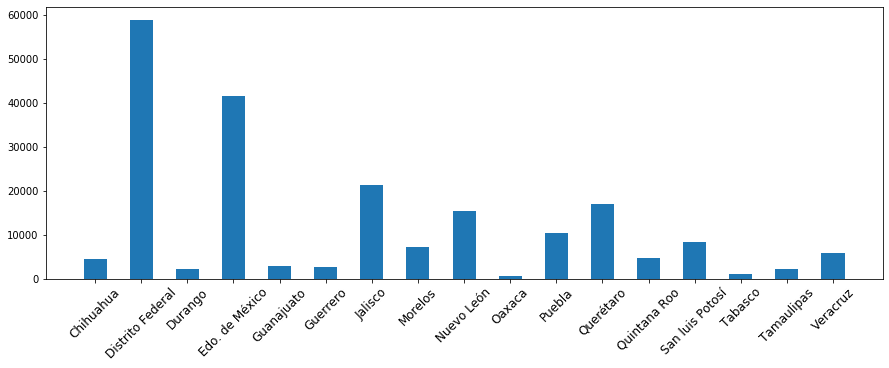

In [50]:
### Visualización de proporción de datos nulos. PUEDE NO SER NECESARIO
plt.figure(figsize = (15,5))

prov_tot = df_joined['cant_total']
prov_nul = df_joined['cant_nulos']
ancho = 0.5
ind = df_joined['provincia']
p1 = plt.bar(ind, prov_tot, ancho)
p2 = plt.bar(ind, prov_nul, ancho)
plt.xticks(rotation = 45, fontsize = 12)

plt.show()

Se ve que no representan más del 1% de los casos totales. Enonces se pueden eliminar.

In [17]:
df_abool.isnull().sum()

ciudad                        217
provincia                       0
gimnasio                        0
usosmultiples                   0
piscina                         0
escuelascercanas                0
centroscomercialescercanos      0
precio                          0
dtype: int64

In [18]:
df_abool.shape

(239845, 8)

In [19]:
df_abool.dropna(inplace = True)
df_abool.isnull().sum()

ciudad                        0
provincia                     0
gimnasio                      0
usosmultiples                 0
piscina                       0
escuelascercanas              0
centroscomercialescercanos    0
precio                        0
dtype: int64

In [20]:
df_abool.shape

(239628, 8)

Media del precio de las propiedades con gimnasio $ 3812891
Media del precio de las propiedades sin gimnasio $ 2445053



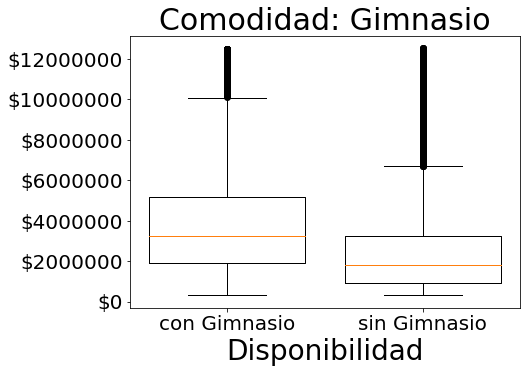

In [21]:
# Comparación directa de los servicios y disponibilidades de las propiedades

print('Media del precio de las propiedades con gimnasio $ {:.0f}'
      .format(df_abool.loc[df_abool['gimnasio'] == True]['precio'].mean()))

print('Media del precio de las propiedades sin gimnasio $ {:.0f}\n'
      .format(df_abool.loc[df_abool['gimnasio'] == False]['precio'].mean()))

fig_1 = plt.figure(1, figsize = (7,5))
sub_fig = fig_1.add_subplot(111)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
sub_fig.yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.title("Comodidad: Gimnasio", fontsize = 30)
sub_fig.set_xlabel('Disponibilidad', fontsize = 28)
box_plot = sub_fig.boxplot([df_abool.loc[df_abool['gimnasio'] == True]['precio'], 
                            df_abool.loc[df_abool['gimnasio'] == False]['precio']],
                           labels = ['con Gimnasio', 'sin Gimnasio'],
                           widths = 0.8)

Media del precio de las propiedades con SUM $ 3826889
Media del precio de las propiedades sin SUM $ 2454917



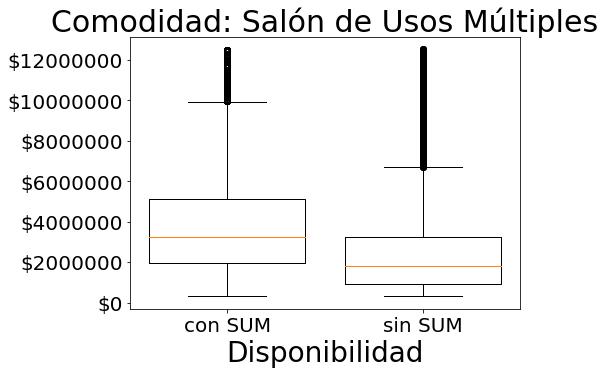

In [22]:
print('Media del precio de las propiedades con SUM $ {:.0f}'
      .format(df_abool.loc[df_abool['usosmultiples'] == True]['precio'].mean()))

print('Media del precio de las propiedades sin SUM $ {:.0f}\n'
      .format(df_abool.loc[df_abool['usosmultiples'] == False]['precio'].mean()))

fig_2 = plt.figure(1, figsize = (7,5))
sub_fig = fig_2.add_subplot(111)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
sub_fig.yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.title("Comodidad: Salón de Usos Múltiples", fontsize = 30)
sub_fig.set_xlabel('Disponibilidad', fontsize = 28)
box_plot = sub_fig.boxplot([df_abool.loc[df_abool['usosmultiples'] == True]['precio'], 
                            df_abool.loc[df_abool['usosmultiples'] == False]['precio']],
                           labels = ['con SUM', 'sin SUM'],
                           widths = 0.8)

Media del precio de las propiedades con piscina $ 3315052
Media del precio de las propiedades sin piscina $ 2455453



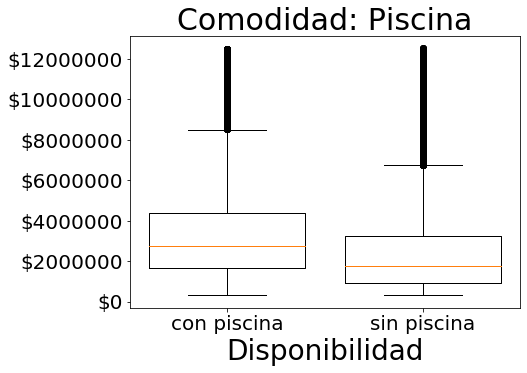

In [23]:
print('Media del precio de las propiedades con piscina $ {:.0f}'
      .format(df_abool.loc[df_abool['piscina'] == True]['precio'].mean()))

print('Media del precio de las propiedades sin piscina $ {:.0f}\n'
      .format(df_abool.loc[df_abool['piscina'] == False]['precio'].mean()))

fig_3 = plt.figure(1, figsize = (7,5))
sub_fig = fig_3.add_subplot(111)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
sub_fig.yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.title("Comodidad: Piscina", fontsize = 30)
sub_fig.set_xlabel('Disponibilidad', fontsize = 28)
box_plot = sub_fig.boxplot([df_abool.loc[df_abool['piscina'] == True]['precio'],
                            df_abool.loc[df_abool['piscina'] == False]['precio']],
                           labels = ['con piscina', 'sin piscina'],
                           widths = 0.8)

Media del precio de las propiedades con escuelas cercanas $ 2533456
Media del precio de las propiedades sin escuelas cercanas $ 2528336



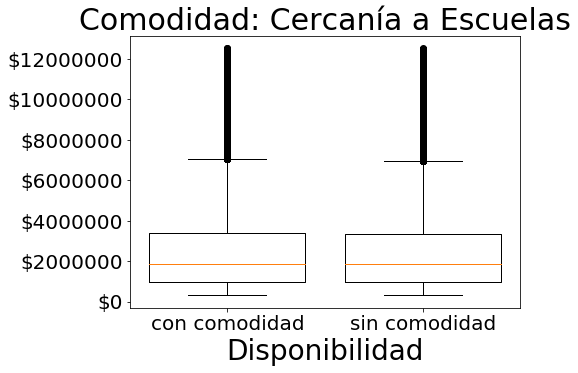

In [24]:
print('Media del precio de las propiedades con escuelas cercanas $ {:.0f}'
      .format(df_abool.loc[df_abool['escuelascercanas'] == True]['precio'].mean()))

print('Media del precio de las propiedades sin escuelas cercanas $ {:.0f}\n'
      .format(df_abool.loc[df_abool['escuelascercanas'] == False]['precio'].mean()))

fig_4 = plt.figure(1, figsize = (7,5))
sub_fig = fig_4.add_subplot(111)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
sub_fig.yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.title("Comodidad: Cercanía a Escuelas", fontsize = 30)
sub_fig.set_xlabel('Disponibilidad', fontsize = 28)
box_plot = sub_fig.boxplot([df_abool.loc[df_abool['escuelascercanas'] == True]['precio'],
                            df_abool.loc[df_abool['escuelascercanas'] == False]['precio']],
                           labels = ['con comodidad', 'sin comodidad'],
                           widths = 0.8)

Media del precio de las propiedades con centros comerciales cencanos $ 2605484
Media del precio de las propiedades sin centros comerciales cencanos $ 2481294



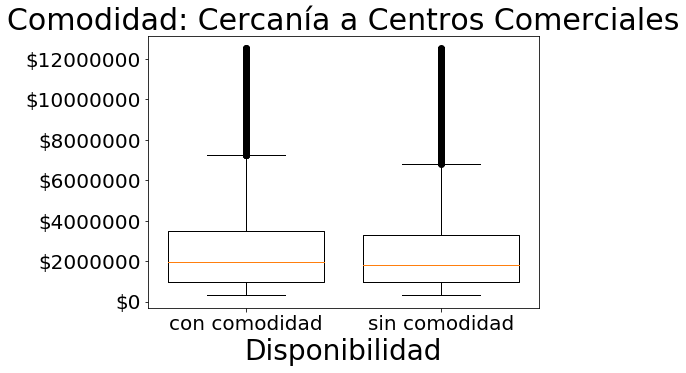

In [25]:
print('Media del precio de las propiedades con centros comerciales cencanos $ {:.0f}'
      .format(df_abool.loc[df_abool['centroscomercialescercanos'] == True]['precio'].mean()))

print('Media del precio de las propiedades sin centros comerciales cencanos $ {:.0f}\n'
      .format(df_abool.loc[df_abool['centroscomercialescercanos'] == False]['precio'].mean()))

fig_5 = plt.figure(1, figsize = (7,5))
sub_fig = fig_5.add_subplot(111)
plt.xticks(rotation = 0, fontsize = 20)
plt.yticks(fontsize = 20)
# Para formatear los ejes
sub_fig.yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.title("Comodidad: Cercanía a Centros Comerciales", fontsize = 30)
sub_fig.set_xlabel('Disponibilidad', fontsize = 28)
box_plot = sub_fig.boxplot([df_abool.loc[df_abool['centroscomercialescercanos'] == True]['precio'],
                            df_abool.loc[df_abool['centroscomercialescercanos'] == False]['precio']],
                           labels = ['con comodidad', 'sin comodidad'],
                           widths = 0.8)

In [26]:
solo_gimnasio = df_abool.loc[(df_abool['gimnasio'] == True) & 
                             (df_abool['usosmultiples'] == False) & 
                             (df_abool['piscina'] == False)]

solo_sum = df_abool.loc[(df_abool['gimnasio'] == False) & 
                        (df_abool['usosmultiples'] == True) & 
                        (df_abool['piscina'] == False)]

solo_piscina = df_abool.loc[(df_abool['gimnasio'] == False) & 
                            (df_abool['usosmultiples'] == False) & 
                            (df_abool['piscina'] == True)]

In [27]:
# Solo con SUM

print('Media del precio de las propiedades con solo Gimnasio $ {:.0f}'
      .format(solo_gimnasio['precio'].mean()))

print('Media del precio de las propiedades con solo SUM $ {:.0f}'
      .format(solo_sum['precio'].mean()))

print('Media del precio de las propiedades con solo Piscina $ {:.0f}'
      .format(solo_piscina['precio'].mean()))

Media del precio de las propiedades con solo Gimnasio $ 3056434
Media del precio de las propiedades con solo SUM $ 3593696
Media del precio de las propiedades con solo Piscina $ 2719016


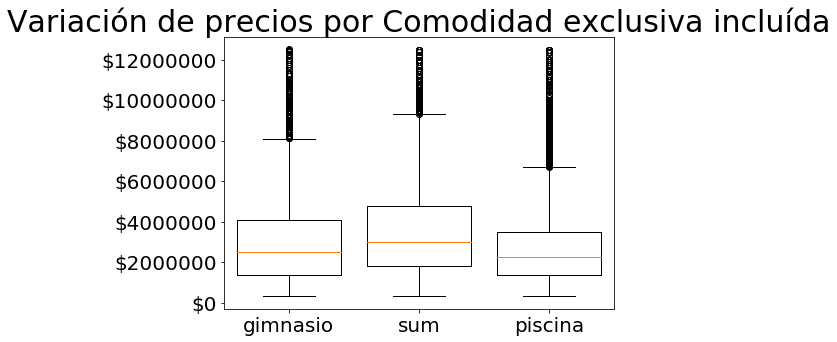

In [28]:
# Análisis por exclusión de las distintas comodidades
fig_6 = plt.figure(6, figsize = (7,5))
sub_fig = fig_6.add_subplot(111)
plt.xticks(rotation = 0, fontsize = 20)
plt.yticks(fontsize = 20)
# Para formatear los ejes
sub_fig.yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.title("Variación de precios por Comodidad exclusiva incluída", fontsize = 30)
box_plot = sub_fig.boxplot([solo_gimnasio['precio'], solo_sum['precio'], solo_piscina['precio']],
                           labels = ['gimnasio', 'sum','piscina'],
                           widths = 0.8)

In [29]:
df_abool.shape

(239628, 8)